In [ ]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
%pip install earthengine-api --upgrade pandas geopandas 
%pip install requests folium osmnx

In [18]:
# Get a bounds of the Sviatohirsk city from OpenStreetMap API
# https://wiki.openstreetmap.org/wiki/Overpass_API
import requests

city_name = 'Кривий Ріг'
city_name_en = "Kryvyi Rih, Ukraine"
url = f'https://overpass-api.de/api/interpreter?data=[out:json]; area[name="{city_name}"] -> .a; ( relation(area.a)[admin_level]; ); out geom;'
print(url)

response = requests.get(url)
data = response.json()
bounds = data['elements'][0]['bounds']

# Make a geojson file with bounds as a polygon
geoJSON = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['minlat']]
                    ]
                ]
            }
        }
    ]
}

bounds

https://overpass-api.de/api/interpreter?data=[out:json]; area[name="Кривий Ріг"] -> .a; ( relation(area.a)[admin_level]; ); out geom;


{'minlat': 47.4566155,
 'minlon': 32.9595518,
 'maxlat': 48.3185181,
 'maxlon': 34.2378723}

In [19]:
# Plot the bounds on the map with folium
# https://python-visualization.github.io/folium/

import folium
import json

center=[(bounds['minlat'] + bounds['maxlat']) / 2, (bounds['minlon'] + bounds['maxlon']) / 2]
m = folium.Map(location=center, zoom_start=11)
folium.GeoJson(json.dumps(geoJSON)).add_to(m)
m

In [20]:

import pandas as pd
import geopandas as gpd


In [21]:
# Translate Lat/Lon bounds of the city to Quadkeys to download building footprints
import math

def lat_lon_to_pixel(latitude, longitude, zoom):
    sinLatitude = math.sin(latitude * math.pi/180)
    pixelX = ((longitude + 180) / 360) * 256 * 2**zoom
    pixelY = (0.5 - math.log((1 + sinLatitude) / (1 - sinLatitude)) / (4 * math.pi)) * 256 * 2**zoom
    return pixelX, pixelY

def pixel_to_tile(pixelX, pixelY):
    return int(math.floor(pixelX / 256)), int(math.floor(pixelY / 256))

def tile_to_quadkey(tileX, tileY, zoom):
    quadkey = ""
    for i in range(zoom, 0, -1):
        digit = 0
        mask = 1 << (i - 1)
        if (tileX & mask) != 0:
            digit += 1
        if (tileY & mask) != 0:
            digit += 2
        quadkey += str(digit)
    return quadkey

# Define the bounding box for Sviatohirsk
minlat, minlon, maxlat, maxlon = bounds['minlat'], bounds['minlon'], bounds['maxlat'], bounds['maxlon']

# Choose a zoom level (adjust as needed to cover the city area)
zoom_level = 12

# Convert the bounding box corners to pixel coordinates
min_pixelX, min_pixelY = lat_lon_to_pixel(minlat, minlon, zoom_level)
max_pixelX, max_pixelY = lat_lon_to_pixel(maxlat, maxlon, zoom_level)

# Convert pixel coordinates to tile coordinates
min_tileX, min_tileY = pixel_to_tile(min_pixelX, min_pixelY)
max_tileX, max_tileY = pixel_to_tile(max_pixelX, max_pixelY)

# Find Quadkeys for each corner (you might need to find all Quadkeys in the range for full coverage)
quadkey_min = tile_to_quadkey(min_tileX, min_tileY, zoom_level)
quadkey_max = tile_to_quadkey(max_tileX, max_tileY, zoom_level)


# Remove three last digits from the quadkey
# quadkey_min = quadkey_min[:-3]
# quadkey_max = quadkey_max[:-3]

print('Quadkey coordinates of the city:')
quadkey_min, quadkey_max

Quadkey coordinates of the city:


('120321132113', '120330002121')

In [22]:
# Adjusting the approach to account for the full-length Quadkeys

# Define the full-length Quadkeys
def quadkey_to_tile(quadkey):
    tileX, tileY = 0, 0
    zoom = len(quadkey)
    for i in range(zoom, 0, -1):
        mask = 1 << (i - 1)
        if quadkey[zoom - i] == '1':
            tileX |= mask
        elif quadkey[zoom - i] == '2':
            tileY |= mask
        elif quadkey[zoom - i] == '3':
            tileX |= mask
            tileY |= mask
    return tileX, tileY, zoom

# Convert full-length Quadkeys back to tile coordinates
min_tileX, min_tileY, zoom = quadkey_to_tile(quadkey_min)
max_tileX, max_tileY, _ = quadkey_to_tile(quadkey_max)

# Ensure the min and max tile ranges are valid
min_tileX, max_tileX = sorted([min_tileX, max_tileX])
min_tileY, max_tileY = sorted([min_tileY, max_tileY])

# Generate list of all Quadkeys in the bounding box
all_quadkeys = []
for tileX in range(min_tileX, max_tileX + 1):
    for tileY in range(min_tileY, max_tileY + 1):
        all_quadkeys.append(tile_to_quadkey(tileX, tileY, len(quadkey_min)))

all_quadkeys_cropped = list(set(map(lambda x: int(x[:-3]), all_quadkeys)))
all_quadkeys_cropped

[120330020,
 120330022,
 120321130,
 120321131,
 120321132,
 120321133,
 120330002,
 120321112,
 120321113]

In [23]:
# https://github.com/microsoft/GlobalMLBuildingFootprints/blob/main/scripts/make-gis-friendly.py

# Get polygons of building footprints for selected bounding box from Microsoft Building Footprints dataset
from shapely.geometry import shape
import os

# check if file not exists
if not os.path.exists(f'./{city_name.replace(" ","_")}_footprints.geojson'):

    # this is the name of the geography you want to retrieve. update to meet your needs
    location = 'Ukraine'

    dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
    ukraine_links = dataset_links[dataset_links.Location == location]
    sviatohirsk_links = ukraine_links[ukraine_links.QuadKey.isin(all_quadkeys_cropped)]

    print('Total Links: ', len(sviatohirsk_links))


    footprints = []
    for _, row in sviatohirsk_links.iterrows():
        df = pd.read_json(row.Url, lines=True)
        df['geometry'] = df['geometry'].apply(shape)
        footprints.append(gpd.GeoDataFrame(df, crs=4326))

    footprints = pd.concat(footprints)

    # Filter footprints by the city bounds
    footprints.cx[minlon:maxlon, minlat:maxlat].to_file(f'./{city_name.replace(" ","_")}_footprints.geojson', driver='GeoJSON')

In [24]:
# filter footprints by the city polygon with admin boundaries
# Load the city polygon
city_polygon = gpd.read_file(f'./{city_name.replace(" ","_")}_boundary.geojson')

# check if file not exists
if not os.path.exists(f'./{city_name.replace(" ","_")}_footprints_filtered.geojson'):

    # Filter footprints by the city polygon
    footprints_filtered = gpd.overlay(footprints, city_polygon, how='intersection')
    footprints_filtered.to_file(f'./{city_name.replace(" ","_")}_footprints_filtered.geojson', driver='GeoJSON')


In [25]:
# show resulting buildings with folium
# m = folium.Map(location=center, zoom_start=11)
# folium.GeoJson(json.dumps(geoJSON)).add_to(m)
# folium.GeoJson(f'./{city_name.replace(" ","_")}_footprints_filtered.geojson').add_to(m)
# m

In [26]:
%pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [27]:
import osmnx as ox
import geopandas as gpd

def download_buildings_and_convert_to_geojson(city_name, output_filename):
    """
    Download all buildings from a specified city using OSM and convert them to GeoJSON.
    
    Args:
    - city_name: The name of the city to download buildings from.
    - output_filename: The filename for the output GeoJSON file.
    """
    # Configure osmnx to retrieve buildings only
    ox.config(use_cache=True, log_console=True)
    
    # Retrieve buildings from the specified city
    buildings_gdf = ox.geometries_from_place(city_name, tags={'building': True})
    
    # Convert the GeoDataFrame to GeoJSON format
    buildings_geojson = buildings_gdf.to_json()
    
    # Save the GeoJSON to a file
    with open(output_filename, 'w') as f:
        f.write(buildings_geojson)
    
    print(f"GeoJSON file has been saved to {output_filename}")

# Example usage

download_buildings_and_convert_to_geojson(city_name_en, f'./{city_name.replace(" ","_")}_osm_buildings.geojson')


C:\Users\klopa\AppData\Local\Temp\ipykernel_6608\3149281314.py:13: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
C:\Users\klopa\AppData\Local\Temp\ipykernel_6608\3149281314.py:16: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  buildings_gdf = ox.geometries_from_place(city_name, tags={'building': True})


GeoJSON file has been saved to ./Кривий_Ріг_osm_buildings.geojson


In [ ]:
%pip install matplotlib

<Axes: >

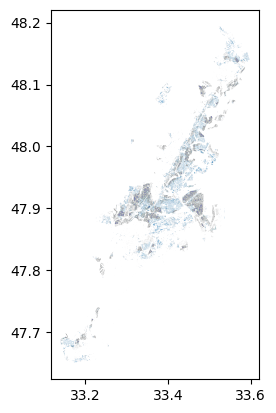

In [30]:
# plot the result on map with gpd plot
gpd.read_file(f'./{city_name.replace(" ","_")}_footprints_filtered.geojson').plot()

In [32]:
# join osm_footprints and microsoft_footprints abd delete those osm polygons that intersect with microsoft polygons

# Load the footprints from Microsoft Building Footprints dataset
microsoft_footprints = gpd.read_file(f'./{city_name.replace(" ","_")}_footprints_filtered.geojson')

# Load the footprints from OSM
osm_footprints = gpd.read_file(f'./{city_name.replace(" ","_")}_osm_buildings.geojson')

# filter out only polygons in osm_footprints
osm_footprints = osm_footprints[osm_footprints['geometry'].type == 'Polygon']

# Perform a spatial join to find the intersections
intersections = gpd.overlay(osm_footprints, microsoft_footprints, how='intersection')

# Remove the intersecting footprints from the OSM dataset
osm_footprints = osm_footprints[~osm_footprints.index.isin(intersections.index)]

# join osm_footprins and microsoft_footprints
all_footprints = pd.concat([microsoft_footprints, osm_footprints])

# Save the result to a new GeoJSON file
all_footprints.to_file(f'./{city_name.replace(" ","_")}_all_footprints.geojson', driver='GeoJSON')